In [5]:
#Includes necesarios
from sklearn.ensemble import VotingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import train_test_split

from auxiliar import get_train_set,get_holdout_set,create_prediction
import preprocessing as pr

from auxiliar import plot_cm,plot_tree
from sklearn.metrics import classification_report,plot_roc_curve

# **Voting**

Para este tipo de ensamble elejiremos aquellos mejores modelos que tuvieron un buen resultado de la metrica *roc_auc*. Esto son:

      - Arbol de Decision: Best params {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 41}
      - Boosting: Best params {'n_estimators': 300, 'min_samples_leaf': 100, 'max_features': 'sqrt', 'max_depth': 10, 'loss': 'deviance', 'learning_rate': 0.1}
      - Red Neuronal

Obtenemos el dataset con el cual entrenaremos nuestro modelo. Para este modelo se opto unicamente tratar los missings como categoricos:

In [3]:
X,y = get_train_set()
X = pr.init_dataset(X)

Aplicamos OHE a nuestras columnas categoricas debido a que todos nuestros modelos entienden valores numericos:

In [10]:
pr.init_OHE(X)
X_ohe = pr.apply_OHE(X)

Creamos los modelos mencionados con los mejores hiperparametros encontrados en su respectivo archivo.

In [11]:
model_tree = DecisionTreeClassifier(max_depth=11, min_samples_leaf=41)
model_boosting = GradientBoostingClassifier(max_depth=10, max_features='sqrt',min_samples_leaf=100, n_estimators=300,random_state=0)

Partimos nuestro set en *train* y *validation*:

In [12]:
X_train, X_validation, y_train, y_validation = train_test_split(X_ohe,y, test_size=0.2, stratify=y, random_state=0)

## Hard Voting

Primero veremos como funciona el ensamble Voting Hard

In [13]:
model_votinghard = VotingClassifier(estimators=[('tree', model_tree), ('boosting', model_boosting)], voting='hard')

Entrenamos con el training set:

In [16]:
model_votinghard.fit(X_train,y_train)

VotingClassifier(estimators=[('tree',
                              DecisionTreeClassifier(max_depth=11,
                                                     min_samples_leaf=41)),
                             ('boosting',
                              GradientBoostingClassifier(max_depth=10,
                                                         max_features='sqrt',
                                                         min_samples_leaf=100,
                                                         n_estimators=300,
                                                         random_state=0))])

Predigo con el validation set:

In [17]:
votinghard_predict = model_votinghard.predict(X_validation)

**Metricas**

In [19]:
print(classification_report(y_validation, votinghard_predict))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4945
           1       0.80      0.58      0.67      1568

    accuracy                           0.86      6513
   macro avg       0.84      0.77      0.79      6513
weighted avg       0.86      0.86      0.86      6513



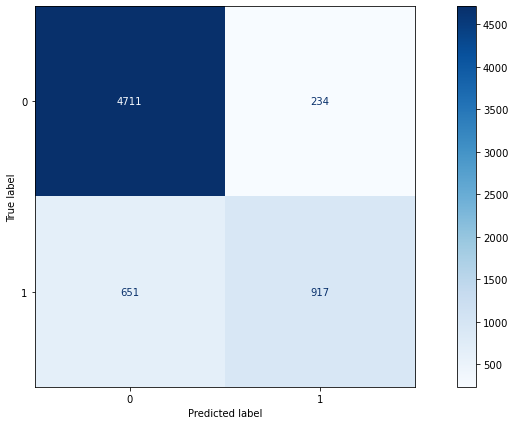

In [20]:
plot_cm(model_votinghard, X_validation, y_validation)

## Soft Voting

Ahora veremos como funciona el ensamble Voting Soft

In [22]:
model_votingsoft = VotingClassifier(estimators=[('tree', model_tree), ('boosting', model_boosting)], voting='soft')

Entrenamos con el training set:

In [23]:
model_votingsoft.fit(X_train,y_train)

VotingClassifier(estimators=[('tree',
                              DecisionTreeClassifier(max_depth=11,
                                                     min_samples_leaf=41)),
                             ('boosting',
                              GradientBoostingClassifier(max_depth=10,
                                                         max_features='sqrt',
                                                         min_samples_leaf=100,
                                                         n_estimators=300,
                                                         random_state=0))],
                 voting='soft')

Predigo con el validation set:

In [25]:
votingsoft_predict = model_votingsoft.predict(X_validation)

**Metricas**

In [26]:
print(classification_report(y_validation, votingsoft_predict))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4945
           1       0.78      0.62      0.69      1568

    accuracy                           0.87      6513
   macro avg       0.83      0.78      0.80      6513
weighted avg       0.86      0.87      0.86      6513



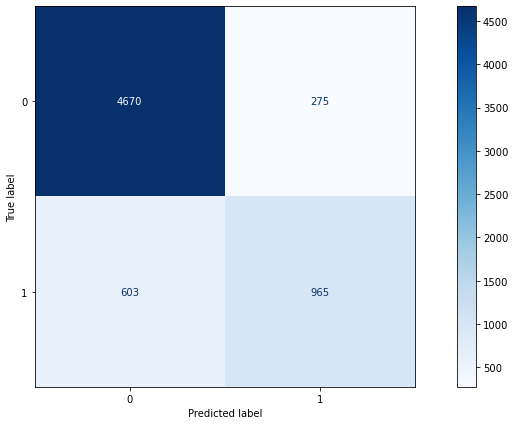

In [27]:
plot_cm(model_votingsoft, X_validation, y_validation)

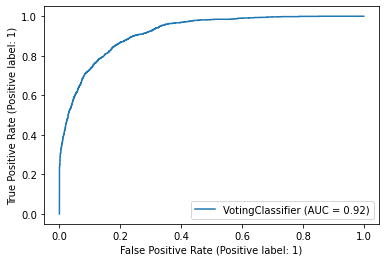

In [30]:
plot_roc_curve(model_votingsoft, X_validation, y_validation, response_method="predict_proba")
plt.show()